In [30]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [31]:
nabil = pd.read_csv("nabil_1yr.csv")
nabil.head()

,SN,Close
0,1,1450.0
1,2,1480.0
2,3,1499.0
3,4,1524.0
4,5,1485.0


In [32]:
df = nabil[['Close']]
df

,Close
0,1450.0
1,1480.0
2,1499.0
3,1524.0
4,1485.0
...,...
359,737.0
360,729.0
361,720.0
362,770.0


### Plotting the target variable:

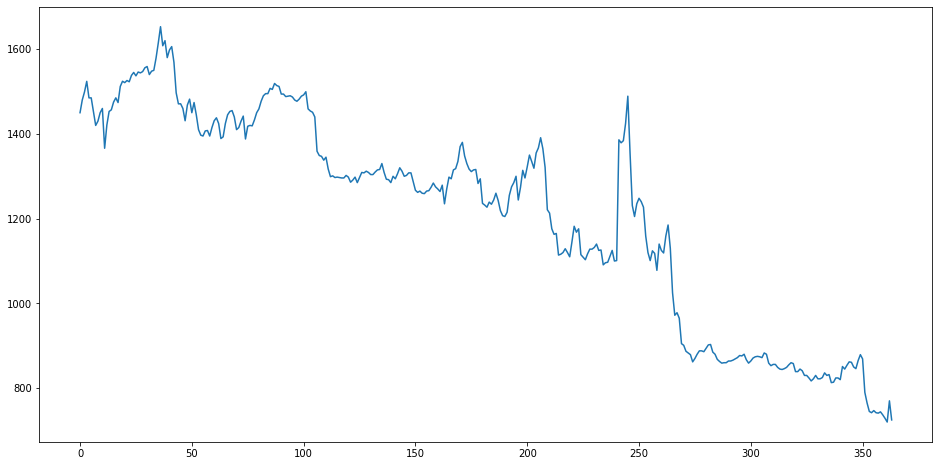

In [33]:
#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

## Using LSTM:

In [34]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [35]:
#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Close'])
for i in range(0,len(data)):
    new_data['Close'][i] = data['Close'][i]

In [36]:
#creating train and test sets
dataset = new_data.values

train = dataset[0:300,:]
valid = dataset[300:,:]

In [37]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [38]:
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

### Creating the LSTM model:

In [39]:
regressor = Sequential()

regressor.add(LSTM(units=50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

In [40]:
regressor.compile(loss='mean_squared_error', optimizer='adam')
regressor.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

240/240 - 19s - loss: 0.0343


In [41]:
#predicting values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = regressor.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

### Result Demo:

In [42]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

43.297293461364916

C:\Users\ASUS\AppData\Local\Temp/ipykernel_14728/1233336585.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price


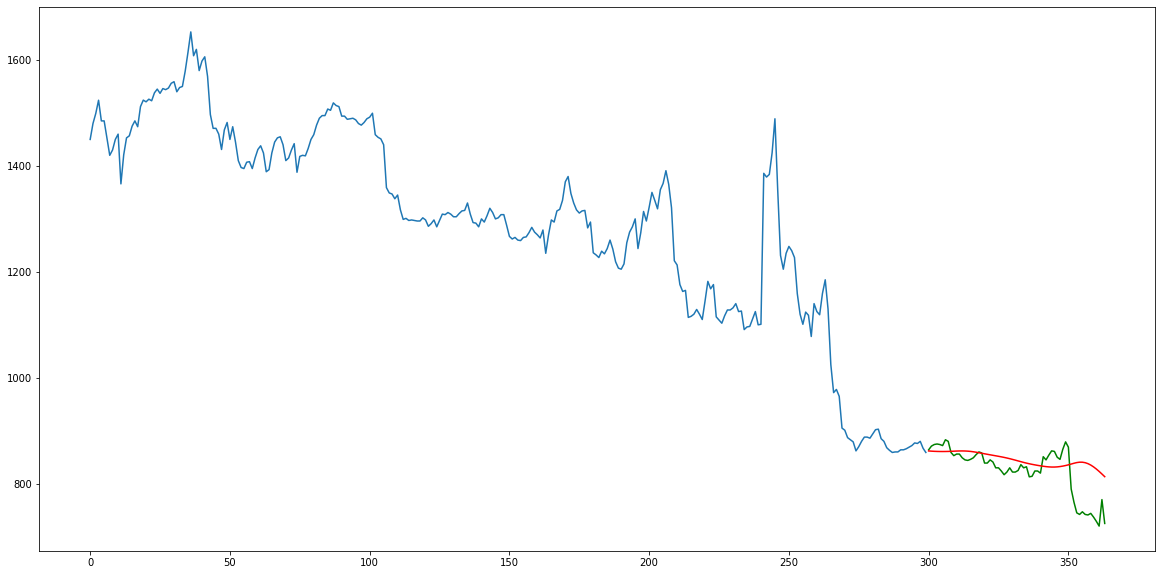

In [43]:
#for plotting
train = new_data[:300]
valid = new_data[300:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close']], color='green')
plt.plot(valid[['Predictions']], color='red')